In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import os
from joblib import load
from tabulate import tabulate
import sys
sys.path.append('..')
from utils import get_meta_data

In [2]:
BASE_PATH = '/home/amir/code/tree_exp/'

In [3]:
dataset_names = np.array(['ionosphere', 'wdbc', 'breast-w', 'diabetes', 'qsar-biodeg',
           'banknote-authentication', 'spambase', 'kdd_ipums_la_97-small',
           'phoneme', 'eye_movements', 'pol', 'MagicTelescope', 'house_16H',
           'electricity', 'MiniBooNE', 'covertype', 'Higgs', 'steel-plates-fault', 
                     'blood-transfusion-service-center', 'mozilla4'])
dataset_names_alt = np.array(['Ionosphere', 'WDBC', 'Wisconsin', 'Diabetes', 'Qsar-Biodeg',
           'Banknote Auth', 'Spambase', 'KDD IPUMS (Small)',
           'Phoneme', 'Eye Movements', 'Pol', 'Magic Telescope', 'House 16H',
           'Electricity', 'MiniBooNE', 'Covertype', 'Higgs', 'Steel Plates Fault', 
                     'Blood Transfusion', 'Mozilla4'])

exp_names = ['lime', 'kernel_shap', 'lpi', 'tree_shap_obs', 'tree_shap_inter', 'local_mdi', 'saabas', 'global', 'random']
exp_names_alt = ['LIME', 'SHAP', 'LPI', 'TSHAP (O)', 'TSHAP (I)', 'LocalMDI', 'Saabas',  'Global', 'Random']

In [4]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)

    return ax

def get_auc(result):
    cutoffs = np.linspace(0.05, 0.5, 10)
    temp = np.array(result).mean(axis=0)
    auc_ = 0
    for k in range(1, len(cutoffs) - 1):
        x = cutoffs[k] - cutoffs[k - 1]
        y = temp[k] + temp[k-1]
        auc = y / ( 2 * x)
    
    return auc

In [5]:
colors = {
    'lime': 'red', 
    'kernel_shap': 'blue', 
    'lpi':'green', 
    'tree_shap_obs': 'magenta', 
    'tree_shap_inter': 'darkgoldenrod', 
    'local_mdi': 'brown', 
    'saabas': 'orange', 
    'global': 'gray',
    'random': 'black'
}

m_name = 'rf'
robust_vals_ = pickle.load( open( "./robust_vals_{}_all.p".format(m_name), "rb" ) )
robust_vals_g = pickle.load( open( "./robust_vals_{}_global.p".format(m_name), "rb" ) )
pickle.dump( temp, open(  "./robust_vals_{}_all_v2.p".format(m_name), "wb" ) )

def merge(a: dict, b: dict, path=[]):
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] != b[key]:
                raise Exception('Conflict at ' + '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a
pickle.dump( temp, open(  "./robust_vals_{}_all_v2.p".format(m_name), "wb" ) )

In [53]:
m_name = 'gb'
robust_vals = pickle.load( open( "./robust_vals_{}_all_v2.p".format(m_name), "rb" ) )
result = []
measure_name = 'insertion'
for i in range(len(dataset_names)):
    for j in range(len(exp_names)): 
        result.append(get_auc(robust_vals['abs'][measure_name][dataset_names[i]][exp_names[j]]))
result = np.array(result)

result_df = pd.DataFrame(result.reshape(len(dataset_names), len(exp_names)), index=dataset_names, columns=exp_names).round(2)
result_df.index = dataset_names_alt
result_df = result_df.sort_index()

print(tabulate(result_df, tablefmt='latex_raw', headers=exp_names_alt))

if measure_name == 'insertion':
    tmp = result_df.style.highlight_min(axis=1)
else:
    tmp = result_df.style.highlight_max(axis=1)
tmp

if measure_name == 'insertion':
    ranked_result = result_df.rank(ascending=True, axis=1)
elif measure_name == 'deletion': 
    ranked_result = result_df.rank(ascending=False, axis=1)

\begin{tabular}{lrrrrrrrrr}
\hline
                    &   LIME &   SHAP &   LPI &   TSHAP (O) &   TSHAP (I) &   LocalMDI &   Saabas &   Global &   Random \\
\hline
 Banknote Auth      &   2.59 &   1.13 &  0.61 &        1.04 &        1.5  &       1.55 &     1.52 &     2.9  &     4.63 \\
 Blood Transfusion  &   2.49 &   1.98 &  1.88 &        1.98 &        1.84 &       2.41 &     2.3  &     2.44 &     2.7  \\
 Covertype          &   2.65 &   0.08 &  0.21 &        0.06 &        0.05 &       0.06 &     0.05 &     0.13 &     4.38 \\
 Diabetes           &   2.98 &   2.22 &  2.11 &        2.58 &        2.28 &       2.86 &     2.67 &     3    &     4.31 \\
 Electricity        &   2.01 &   1.07 &  0.94 &        1.28 &        1.15 &       2.63 &     1.66 &     0.9  &     5.52 \\
 Eye Movements      &   0.99 &   0.72 &  0.88 &        0.74 &        0.71 &       0.85 &     0.83 &     0.71 &     2.9  \\
 Higgs              &   0.83 &   0.47 &  0.25 &        0.36 &        0.4  &       0.6  &     0.61

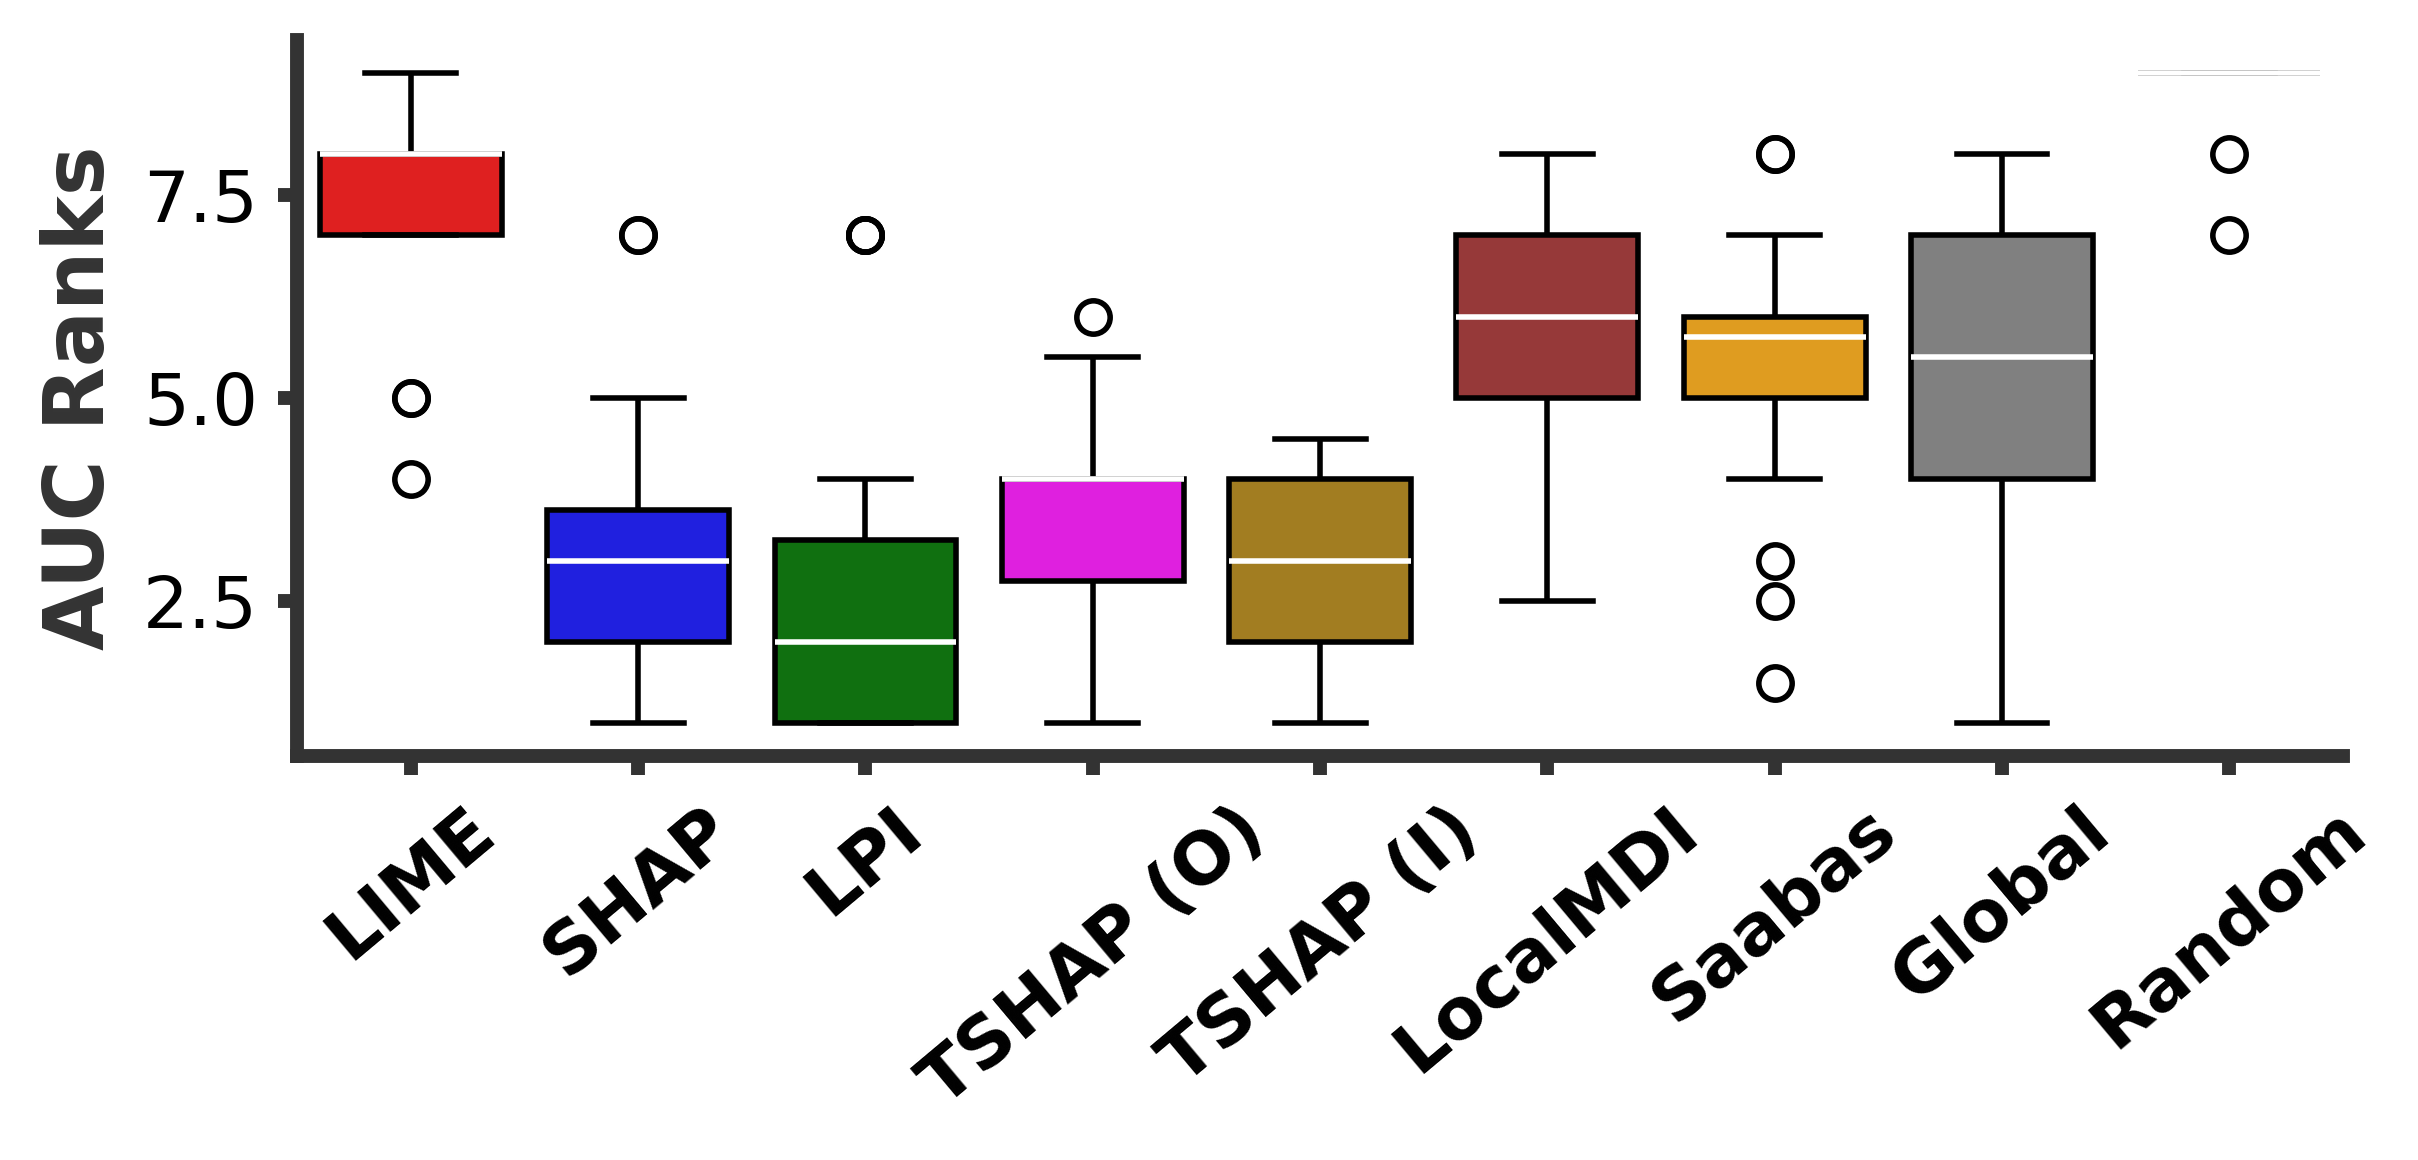

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=400)
palette = colors.values()
sns.boxplot(ranked_result, ax=ax, palette=palette, medianprops=dict(color="white"))
ax.set_xticks(np.arange(len(exp_names)))
ax.set_ylabel('AUC Ranks')
ax.set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')
ax = process_ax(ax)
plt.tight_layout()
plt.savefig('../figs/boxplot_{}_{}.pdf'.format(m_name, measure_name))

plt.show()

In [55]:
meta = get_meta_data()
meta.index = dataset_names_alt
meta = meta.sort_index()

In [56]:
total_df = pd.concat([result_df, meta], axis=1)

In [57]:
total_df

,lime,kernel_shap,lpi,tree_shap_obs,tree_shap_inter,local_mdi,saabas,global,random,Training Size,Test Size,Features,GB,RF
Banknote Auth,2.59,1.13,0.61,1.04,1.50,1.55,1.52,2.90,4.63,919,453,4,0.98,0.98
Blood Transfusion,2.49,1.98,1.88,1.98,1.84,2.41,2.30,2.44,2.70,501,247,4,0.79,0.79
Covertype,2.65,0.08,0.21,0.06,0.05,0.06,0.05,0.13,4.38,13400,6600,54,0.78,0.86
Diabetes,2.98,2.22,2.11,2.58,2.28,2.86,2.67,3.00,4.31,514,254,8,0.74,0.76
Electricity,2.01,1.07,0.94,1.28,1.15,2.63,1.66,0.90,5.52,30359,14953,7,0.83,0.88
Eye Movements,0.99,0.72,0.88,0.74,0.71,0.85,0.83,0.71,2.90,7327,3609,24,0.72,0.73
Higgs,0.83,0.47,0.25,0.36,0.40,0.60,0.61,0.38,3.82,13400,6600,28,0.71,0.72
House 16H,1.87,1.36,1.18,1.28,1.39,1.66,1.78,1.80,4.53,15265,7519,16,0.88,0.90
Ionosphere,2.01,0.26,0.51,0.61,0.43,0.62,0.70,0.71,5.12,235,116,34,0.90,0.92
KDD IPUMS (Small),6.39,0.61,2.27,0.78,0.67,0.86,0.85,0.92,5.15,3475,1713,20,0.89,0.88


In [58]:
total_corr = total_df.corr(method='pearson').loc[:, ['Training Size', 'Test Size', 'Features', m_name.upper()]]

In [59]:
total_corr = total_corr.iloc[:7, :]
total_corr

,Training Size,Test Size,Features,GB
lime,-0.119959,-0.119898,-0.209509,0.029151
kernel_shap,0.003887,0.003921,-0.633594,-0.324338
lpi,-0.151861,-0.151800,-0.518850,-0.329463
tree_shap_obs,-0.057199,-0.057164,-0.654375,-0.303053
tree_shap_inter,-0.038337,-0.038303,-0.680248,-0.287778
local_mdi,0.088861,0.088892,-0.785654,-0.183575
saabas,-0.078046,-0.078014,-0.718946,-0.261724


# Visualization

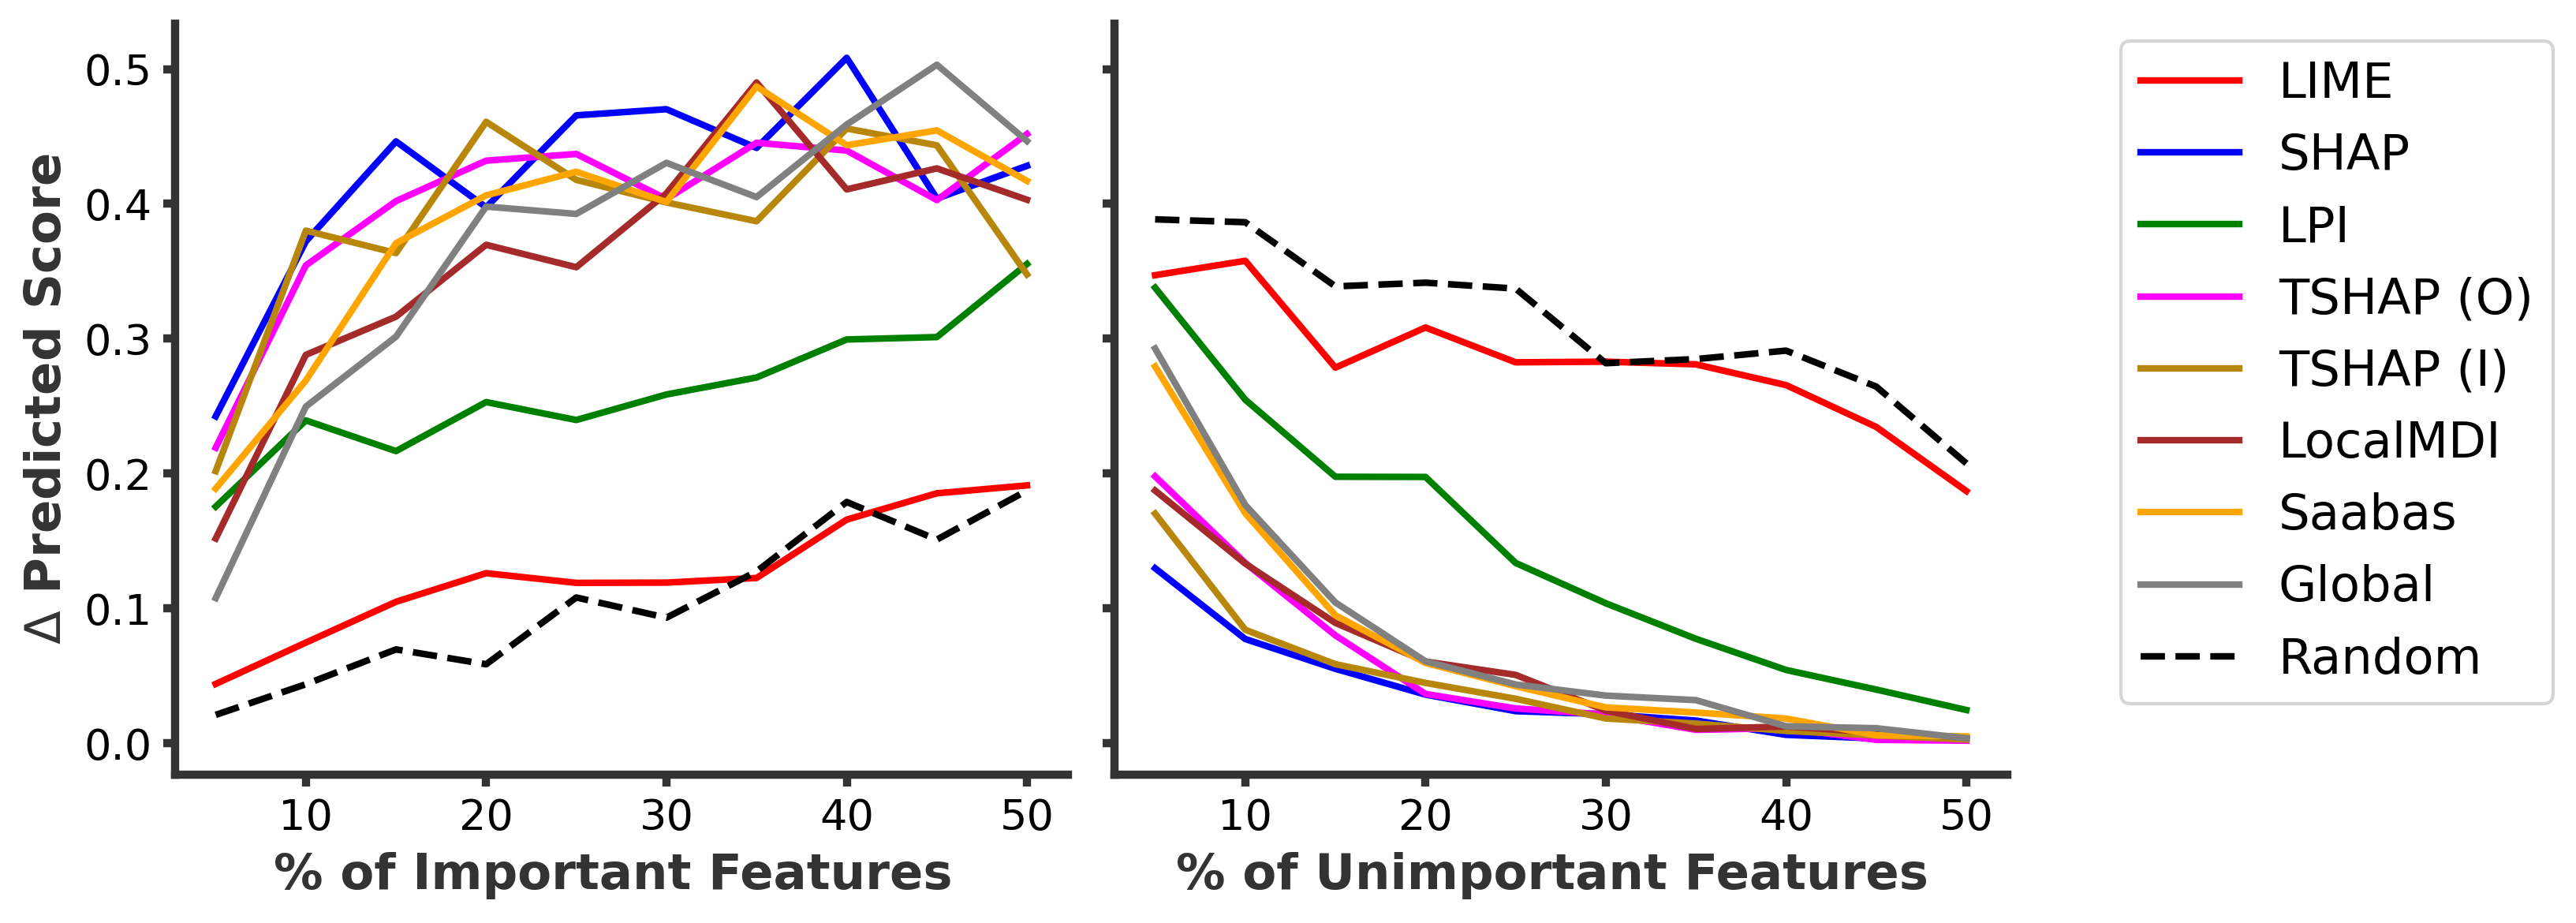

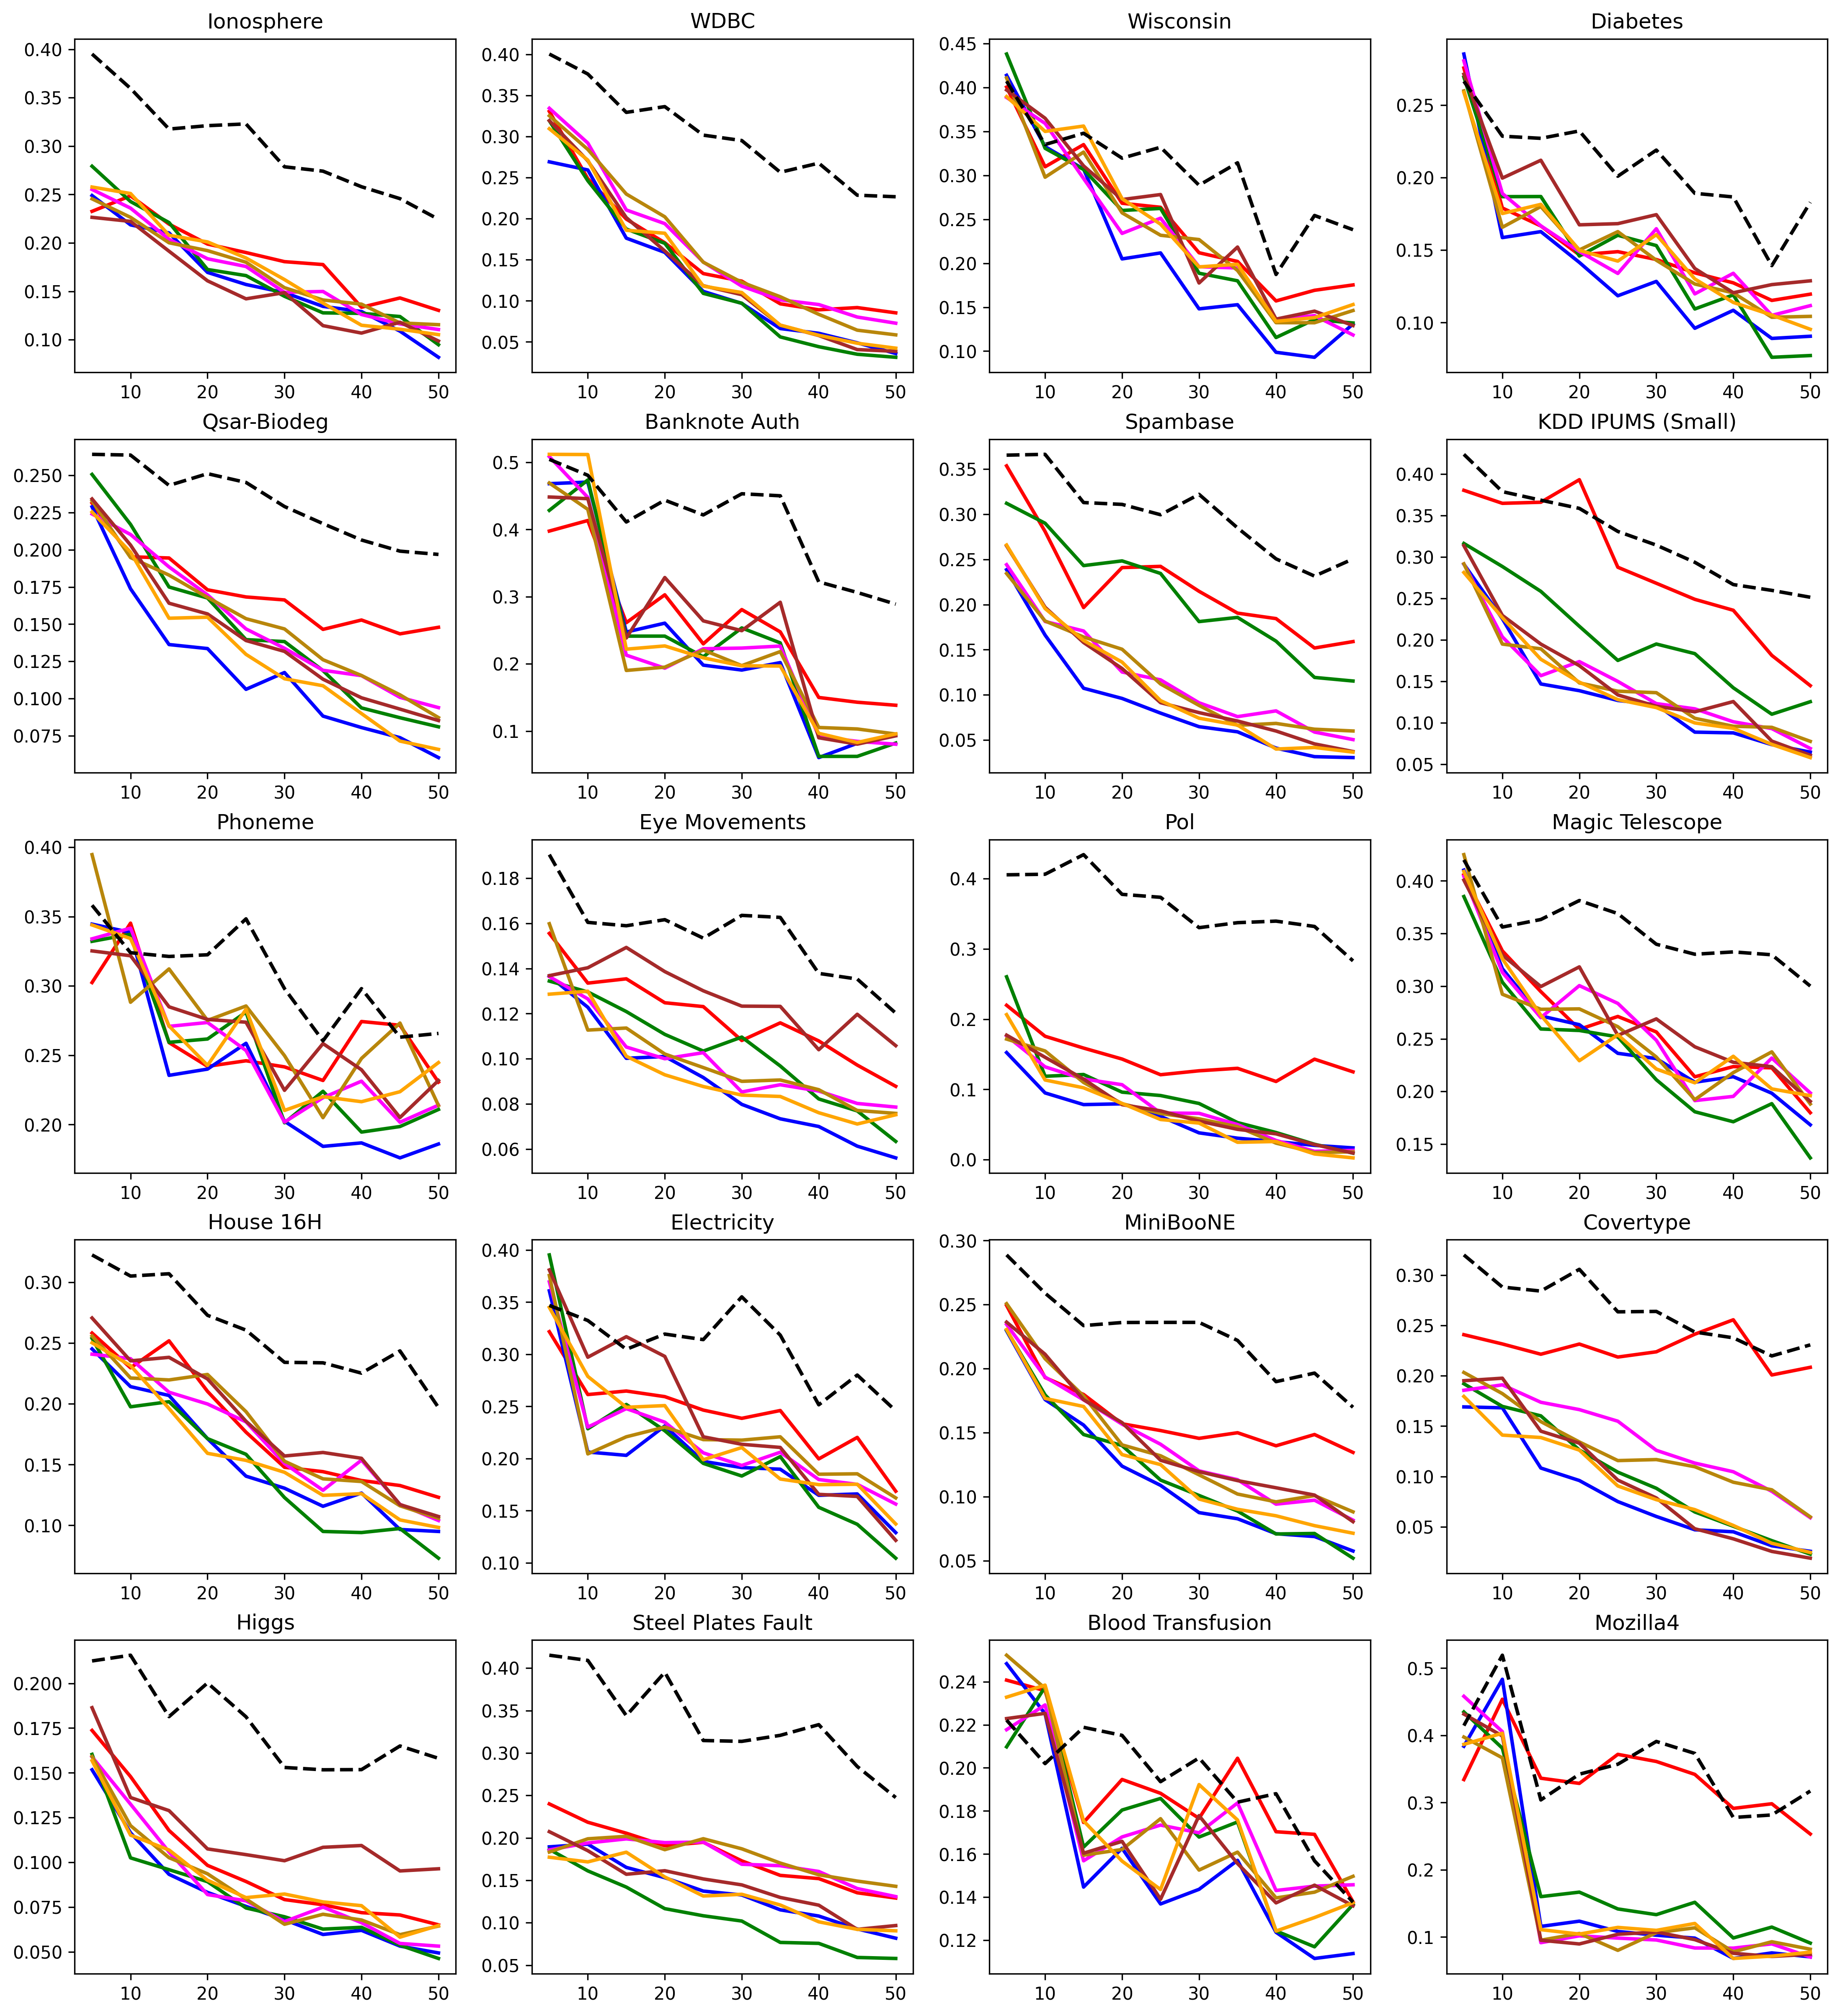

<BarContainer object of 48 artists>

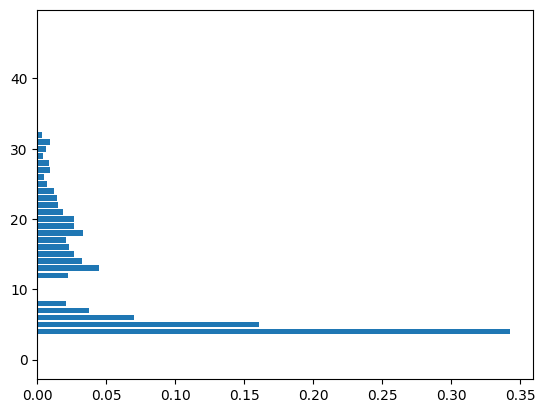